# CoCiP Grid model

Run CoCiP simulation on a grid of infinitesmal flight segments.

## References

- Engberg, Z., Teoh, R., Abbott, T., Dean, T., Stettler, M.E.J., Shapiro, M.L. "Forecasting contrail climate forcing for flight planning and air traffic management applications: The CocipGrid model in pycontrails 0.51.0", (submit 2024) https://doi.org/10.5194/egusphere-2024-1361

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pycontrails.core import MetDataset
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocipgrid import CocipGrid
from pycontrails.models.humidity_scaling import HistogramMatching
from pycontrails.models.ps_model import PSGrid

In [2]:
# Set up time and spatial bounds for the model run
time_bounds = ("2022-03-01 00:00:00", "2022-03-01 23:00:00")
lon_bounds = (-115, -95)
lat_bounds = (30, 50)
pressure_levels = (300, 250)  # hPa

In [3]:
# Download meteorological data
era5 = ERA5(time_bounds, pressure_levels=pressure_levels, variables=CocipGrid.met_variables)
met = era5.open_metdataset()

era5_rad = ERA5(time_bounds, variables=CocipGrid.rad_variables)
rad = era5_rad.open_metdataset()

In [4]:
# Model parameters
params = {
    "dt_integration": np.timedelta64(5, "m"),
    "max_age": np.timedelta64(10, "h"),
    # The humidity_scaling parameter is only used for ECMWF ERA5 data
    # See https://py.contrails.org/api/pycontrails.models.humidity_scaling.html#module-pycontrails.models.humidity_scaling
    "humidity_scaling": HistogramMatching(),
    # Use Poll-Schumann aircraft performance model adapted for grid calculations
    # See https://py.contrails.org/api/pycontrails.models.ps_model.PSGrid.html#pycontrails.models.ps_model.PSGrid
    "aircraft_performance": PSGrid(),
}

# Initialize CocipGrid model
cocip_grid = CocipGrid(met=met, rad=rad, params=params)

In [5]:
# Create a grid source
coords = {
    "level": pressure_levels,
    "time": pd.date_range(time_bounds[0], time_bounds[1], freq="1h")[
        0:4
    ],  # run for first 4 hours of domain
    "longitude": np.arange(lon_bounds[0], lon_bounds[1], 1.0),
    "latitude": np.arange(lat_bounds[0], lat_bounds[1], 1.0),
}
grid_source = MetDataset.from_coords(**coords)

# Run CocipGrid model
result = cocip_grid.eval(source=grid_source)

CocipGrid eval:   0%|          | 0/66 [00:00<?, ?it/s]

Text(0, 0.5, 'Latitude')

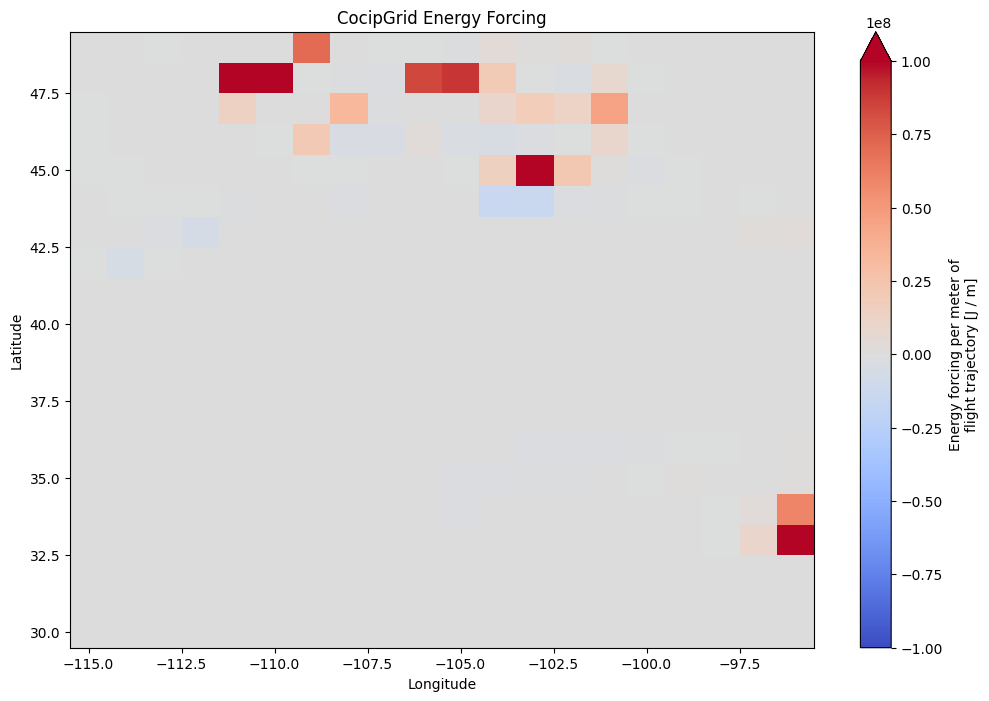

In [6]:
# Plot results
plt.figure(figsize=(12, 8))
ef_per_m = result.data["ef_per_m"].isel(time=0, level=0)
ef_per_m.plot(x="longitude", y="latitude", vmin=-1e8, vmax=1e8, cmap="coolwarm")

plt.title("CocipGrid Energy Forcing")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [7]:
result

MetDataset with data:

<xarray.Dataset>
Dimensions:       (longitude: 20, latitude: 20, level: 2, time: 4)
Coordinates:
  * longitude     (longitude) float64 -115.0 -114.0 -113.0 ... -98.0 -97.0 -96.0
  * latitude      (latitude) float64 30.0 31.0 32.0 33.0 ... 46.0 47.0 48.0 49.0
  * level         (level) float64 250.0 300.0
  * time          (time) datetime64[ns] 2022-03-01 ... 2022-03-01T03:00:00
    air_pressure  (level) float32 2.5e+04 3e+04
    altitude      (level) float32 1.036e+04 9.164e+03
Data variables:
    contrail_age  (longitude, latitude, level, time) float32 0.0 0.0 ... 0.0 0.0
    ef_per_m      (longitude, latitude, level, time) float32 0.0 0.0 ... 0.0 0.0
Attributes: (12/13)
    humidity_scaling_name:     histogram_matching
    humidity_scaling_formula:  era5_quantiles -> iagos_quantiles
    azimuth:                   0.0
    segment_length:            1000.0
    met_source_provider:       ECMWF
    met_source_dataset:        ERA5
    ...                        ...
    aircraft_type:             B737
    description:               Gridded Contrail Cirrus Prediction Model
    max_age:                   10 hours
    dt_integration:            5 minutes
    pycontrails_version:       0.53.2.dev10
    ap_model:                  PSGrid

In [8]:
# work with the results
print("Mean energy forcing per flight meter:", ef_per_m.mean().item())
print("Max energy forcing per flight meter:", ef_per_m.max().item())
print("Min energy forcing per flight meter:", ef_per_m.min().item())

contrail_age = result.data["contrail_age"].isel(time=0, level=0)
print("Mean contrail age:", contrail_age.mean().item())

Mean energy forcing per flight meter: 3912748.25
Max energy forcing per flight meter: 573449152.0
Min energy forcing per flight meter: -14353982.0
Mean contrail age: 0.1743749976158142
